In [1]:
# Needed for static or interactive matplotlib plots
%matplotlib inline

import sys

import concurrent.futures

from scipy.signal import convolve2d
from scipy.sparse import diags, csr_matrix, bsr_matrix, spdiags, lil_matrix, dok_matrix
from scipy.sparse.linalg import aslinearoperator

from skimage import data, io, color
from skimage.transform import resize

from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
def matrix_memory(m):
    return (m.data.nbytes + m.indptr.nbytes + m.indices.nbytes) / 10**6 # MB

def matrix_density(m):
    return m.getnnz() / np.prod(m.shape)

def show_image(image, title):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def show_sparse_matrix(image, title):
    plt.spy(image)
    plt.title(title)
    plt.show()
    
def gaussian(l=5, sig=1.):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 
    
def conv_matrix_padded(l, kernel, zero_padding=False):
    k_supp = kernel.shape[0]
    k_half_supp = (k_supp-1)//2
    k_samples = k_supp**2
    padding_pixels = k_half_supp if zero_padding else 0
    col_offsets = np.repeat(np.arange(k_supp) - k_half_supp, k_supp) * (l+padding_pixels*2 - k_supp)
    diagonal_offsets = (np.arange(k_samples) - (k_samples-1)//2) + col_offsets
    matrix_size = ( l + padding_pixels * 2 )**2
    return diags(kernel.flatten(), diagonal_offsets, shape=(matrix_size, matrix_size), dtype=np.float32)

def decimation_matrix(original_dim, downsample_factor, padding):
    
    if original_dim % downsample_factor != 0:
        raise ValueError(f"Downsample factor {downsample_factor} is not a valid factor of your matrix dimension {original_dim}.")
    if downsample_factor == original_dim:
        raise ValueError(f"Downsample factor {downsample_factor} cannot be the same as your matrix dimension {original_dim}.")
    if downsample_factor == 1: # effectively, no downsampling
        return np.identity(original_dim**2)
    # Otherwise assumed you want to downsample by a valid factor of original_dim...
    
    sampling_regions_per_dim = original_dim // downsample_factor
    samples_per_region_dim = downsample_factor
    # print(f"Sampling regions per dimension: {sampling_regions_per_dim}")
    # print(f"Samples per dimension: {samples_per_region_dim}")
    non_zero_entries = sampling_regions_per_dim**2 * samples_per_region_dim**2
    # print(f"Non-zero entries: {non_zero_entries}")
    
    rows = np.zeros(non_zero_entries, dtype=np.uintc)   # stores row indices for non-zero compressed sparse matrix entries
    cols = np.zeros(non_zero_entries, dtype=np.uintc)   # stores col indices for non-zero compressed sparse matrix entries
    vals = np.ones(non_zero_entries, dtype=np.ubyte)  # stores element value at [row, col] for non-zero entries
    
    # Generates linear x,y index strides for downsampling
    sample_stride_1D = np.arange(0, original_dim, downsample_factor)
    # print(sample_stride_1D)
    mesh = np.array(np.meshgrid(sample_stride_1D, sample_stride_1D))
    sample_strides_2D = mesh.T.reshape(-1, 2)
  
    neighbour_strides_1D = np.arange(samples_per_region_dim)
    # print(neighbour_strides_1D)
    top_padding = (original_dim + padding*2) * padding
    # print(top_padding)
    neighbour_mesh = np.array(np.meshgrid(neighbour_strides_1D, neighbour_strides_1D))
    # print(neighbour_mesh)

    for index in np.arange(sample_strides_2D.shape[0]):
        neighbour_coords = neighbour_mesh.T.reshape(-1, 2) + sample_strides_2D[index] # generates (row, col) index pair for the nxn neighbours of each sampling point in sample_strides_2D
        # print(f"Neighbour coords: {neighbour_coords}")
        neighbour_coords[:, 0] *= original_dim + padding*2 # scale y coord by high-resolution image dim to enable row striding (due to column-vector matrix flattening)
        # print(f"Neighbour coords: {neighbour_coords}")
        neighbour_coords = np.sum(neighbour_coords, axis=1) + padding + top_padding # combine x and y coord into single array index
        # print(f"Neighbour coords: {neighbour_coords}")
        rows[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = index 
        cols[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = neighbour_coords
        
    return csr_matrix((vals, (rows, cols)), shape=(sampling_regions_per_dim**2, (l+padding*2)**2), dtype=np.ubyte)

In [3]:
# l = 10
# k_supp = 3
# k_supp_half = (k_supp - 1) // 2
# kernel = gaussian(k_supp)
# padded = True
# padding = k_supp_half if padded else 0

# # x_true = color.rgb2gray(data.astronaut())
# # x = resize(x_true, (l, l), anti_aliasing=True)
# # show_image(x, "X")

# # scikit_convolved = normalise(convolve2d(x, kernel.reshape(k_supp, k_supp), mode="same"))
# # show_image(scikit_convolved, "Scikit Convolved")
    
# # x = x.reshape(1, x.shape[0]**2)
# # x = h @ x.T
# # x = x.reshape(l+padding*2, l+padding*2)

# # show_image(normalise(x), "Sharpened X")
# # show_image(np.absolute(scikit_convolved - normalise(x)), "Abs Diff")

# ## Decimation matrix
# downsample_factor = 4
# %time d_lo = (decimation_matrix(l, downsample_factor, padding))
# # show_image(d_lo.todense(), "D")
# #print(matrix_memory(d_lo))

# %time h_lo = (conv_matrix_padded(l, kernel, padding))
# # show_image((h_lo.todense()), "H")

# %time dh = d_lo @ h_lo
# #print(dh.nnz)
# #print(dh.shape)
# #print( (dh.nnz / (dh.shape[0] * dh.shape[1])) * 100.0 )
# # show_sparse_matrix(dh, "DH")
# # show_image(dh.todense(), "DH")
# # print(type(dh))

# # x = np.pad(x, padding)
# # show_image(x, "Padded X")


# # x = dh @ x.reshape(1, x.shape[0]**2).T

# # x = x.reshape(int(np.sqrt(x.shape[0])), int(np.sqrt(x.shape[0])))
# # show_image(x, "Processed X")

# # if padded:
# #     x = x[padding:-padding, padding:-padding]

### Trying to break up matrix mult into stackable partitions

In [4]:
def generate_h_matrix(l, kernel):
    h = conv_matrix(l, kernel)
    print(f"H matrix memory usage: {matrix_memory(h)}MB")
    print(f"H matrix density: {matrix_density(h)}%")
    return h 

def conv_matrix(l, kernel):
    k_supp = kernel.shape[0]
    k_half_supp = (k_supp-1)//2
    k_samples = k_supp**2
    col_offsets = np.repeat(np.arange(k_supp) - k_half_supp, k_supp) * (l - k_supp)
    diagonal_offsets = (np.arange(k_samples) - (k_samples-1)//2) + col_offsets
    m = diags(kernel.flatten(), diagonal_offsets, shape=(l**2, l**2), format="csr", dtype=np.float32)
    
    mask_vals = np.repeat(1.0, k_supp)
    mask_offsets = np.linspace(-k_half_supp, k_half_supp, k_supp, dtype=np.intc)
    mask = diags(mask_vals, mask_offsets, shape=(l, l), format="bsr", dtype=np.float32)
    
    try:
        Parallel(n_jobs=-1, prefer='threads')(delayed(apply_mask)(row, l, k_half_supp, m, mask) for row in range(l))
    except Exception as e:
        print("Error...")
        print(e)
        
    return m  

def apply_mask(r, l, k_half_supp, m, mask):
    col_chunk_min = max(0, r-k_half_supp-1)
    col_chunk_max = min(l-1, r+k_half_supp+1)
    
    for c in range(col_chunk_min, col_chunk_max+1):
        m[r*l:r*l+l, c*l:c*l+l] = m[r*l:r*l+l, c*l:c*l+l].multiply(mask)
        
def decimation_matrix(original_dim, downsample_factor):
    
    if original_dim % downsample_factor != 0:
        raise ValueError(f"Downsample factor {downsample_factor} is not a valid factor of your matrix dimension {original_dim}.")
    if downsample_factor == original_dim:
        raise ValueError(f"Downsample factor {downsample_factor} cannot be the same as your matrix dimension {original_dim}.")
    if downsample_factor == 1: # effectively, no downsampling
        return np.identity(original_dim**2)
    # Otherwise assumed you want to downsample by a valid factor of original_dim...
    
    sampling_regions_per_dim = original_dim // downsample_factor
    samples_per_region_dim = downsample_factor
    # print(f"Sampling regions per dimension: {sampling_regions_per_dim}")
    # print(f"Samples per dimension: {samples_per_region_dim}")
    non_zero_entries = sampling_regions_per_dim**2 * samples_per_region_dim**2
    # print(f"Non-zero entries: {non_zero_entries}")
    
    rows = np.zeros(non_zero_entries, dtype=np.uintc)   # stores row indices for non-zero compressed sparse matrix entries
    cols = np.zeros(non_zero_entries, dtype=np.uintc)   # stores col indices for non-zero compressed sparse matrix entries
    vals = np.ones(non_zero_entries, dtype=np.float32)  # stores element value at [row, col] for non-zero entries
    
    # Generates linear x,y index strides for downsampling
    sample_stride_1D = np.arange(0, original_dim, downsample_factor)
    # print(sample_stride_1D)
    mesh = np.array(np.meshgrid(sample_stride_1D, sample_stride_1D))
    sample_strides_2D = mesh.T.reshape(-1, 2)
  
    neighbour_strides_1D = np.arange(samples_per_region_dim)
    neighbour_mesh = np.array(np.meshgrid(neighbour_strides_1D, neighbour_strides_1D))

    for index in np.arange(sample_strides_2D.shape[0]):
        neighbour_coords = neighbour_mesh.T.reshape(-1, 2) + sample_strides_2D[index] # generates (row, col) index pair for the nxn neighbours of each sampling point in sample_strides_2D
        neighbour_coords[:, 0] *= original_dim # scale y coord by high-resolution image dim to enable row striding (due to column-vector matrix flattening)
        neighbour_coords = np.sum(neighbour_coords, axis=1) # combine x and y coord into single array index
        rows[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = index
        cols[index * neighbour_coords.shape[0] : (index + 1) * neighbour_coords.shape[0]] = neighbour_coords
        
    return (csr_matrix((vals, (rows, cols))))

In [5]:
l = 40
k_supp = 3
kernel = gaussian(k_supp)
df = 2

d = decimation_matrix(l, df)
# show_image(d.todense(), "D")

h = generate_h_matrix(l, kernel)
# show_image(h.todense(), "H")

dh = d @ h
# show_image(dh.todense(), "DH")

H matrix memory usage: 0.119668MB
H matrix density: 0.00553046875%


In [6]:
dhp = dok_matrix((d.shape[0], h.shape[1]), dtype=np.float32)
print(dhp.shape)

chunk_dim = l

def dhp_distributed_mat_mul(r, chunk_dim, l, h, d):
    local_dhp = dok_matrix((d.shape[0], h.shape[1]), dtype=np.float32)
    # for h_row_chunk in np.arange(0, l**2, chunk_dim):
    for h_col_chunk in np.arange(0, l**2, chunk_dim):
        # print(f"{d_row} -> {h_col_chunk}")
        h_chunk = dok_matrix((h.shape), dtype=np.float32)
        h_chunk[r*chunk_dim:r*chunk_dim+chunk_dim, h_col_chunk:h_col_chunk+chunk_dim] = h[r*chunk_dim:r*chunk_dim+chunk_dim, h_col_chunk:h_col_chunk+chunk_dim]
        chunk_sum = dok_matrix.sum(h_chunk)
        
        if(chunk_sum == 0.0):
            # print(f"Shit is zero: {chunk_sum}")
            continue
            # show_image(h_chunk.todense(), f"H Chunk ({h_col_chunk})")

        local_dhp += d @ h_chunk
    return local_dhp

(400, 1600)


In [7]:
%%time 

# NOTES TO SELF: I wonder if I can do something about threading over y dim too as well as x, currently only doing x. Wonder where I can trim fat too... still kinda sluggish

with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
    future_to_dhp = {executor.submit(dhp_distributed_mat_mul, r, chunk_dim, l, h, d): r for r in range(chunk_dim)}
    for future in concurrent.futures.as_completed(future_to_dhp):
        derp = future_to_dhp[future]
        try:
            # show_image(future.result().todense(), "DHP")
            dhp += future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (derp, exc))
        else:
            pass
            # print('%r page is %d bytes' % (derp, len(data)))
            
# for d_row in np.arange(0, l//df, l//df): # np.arange(0, d.shape[0], l//df): # range(d.shape[0]):
# for h_row_chunk in np.arange(0, l**2, chunk_dim):
#     for h_col_chunk in np.arange(0, l**2, chunk_dim):
#         # print(f"{d_row} -> {h_col_chunk}")
#         h_chunk = dok_matrix((h.shape), dtype=np.float32)
#         h_chunk[h_row_chunk:h_row_chunk+chunk_dim, h_col_chunk:h_col_chunk+chunk_dim] = h[h_row_chunk:h_row_chunk+chunk_dim, h_col_chunk:h_col_chunk+chunk_dim]

#         # if(lil_matrix.sum(h_chunk) != 0.0):
#         #     show_image(h_chunk.todense(), f"H Chunk ({h_col_chunk})")
            
#         dhp += d @ h_chunk

CPU times: user 13.8 s, sys: 504 ms, total: 14.3 s
Wall time: 13.4 s


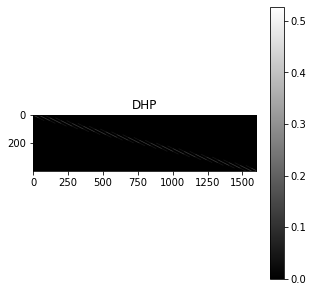

l2 norm diff: 0.0


In [8]:
show_image(dhp.todense(), "DHP")

print(f"l2 norm diff: {np.linalg.norm((dh.todense() - dhp.todense()))}")


# h_clip = lil_matrix((h.shape), dtype=np.float32)
# h_clip[:10, :10] = h[:10, :10]
# show_image(h_clip.todense(), "H Clip")

# dh = d[:10, :] @ h_clip
# show_image(dh.todense(), "DH Clip")

# h_clip = lil_matrix((h.shape), dtype=np.float32)
# h_clip[:10, 10:20] = h[:10, 10:20]
# show_image(h_clip.todense(), "H Clip")
# dh += d[0:10, :] @ h_clip
# show_image(dh.todense(), "DH Clip")